# Introduction
We have data available from US domestic airflights from 1987 to 2008.
We will make a summary report of these delays for 2008 first for the general airline industry and next we will compare the performance of the different carriers.
Finally we will use this data to reduce airport delays for 2009.

In [9]:
# This will assume you prepare the following folder structure:

# US-domestic-airflights      
#  ├───data
#  │   └───2008.csv (bz2)
#  │   └───.....csv
#  ├───exports
#  ├───solution
#  │   └───US-domestic-airflights.ipynb
#  ├───environment.yml
#  └───readme.md

# 1. EDA

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="darkgrid", palette='muted')
%matplotlib inline

import pandas as pd
import numpy as np

from dask.delayed import delayed
import dask.dataframe as dd
import dask

from os.path import dirname, abspath, join, isdir 
import os 
import psutil
import gc
import time
import glob

import warnings
warnings.filterwarnings('ignore')

We will first use dask which is frequently used library to parallellize custom workloads. In dask we can use dask arrays and dask dataframes similar to numpy and pandas to do our analysis. We are able to parallellize the workload and load larger than memory data, to compare our flight delays over all the years. This makes it also scalable to use dask for further analysis, but since we are only interested in 2008 and this data fits in memory, we will let dask do the heavy lifting and pandas the more in detail dataframe manipulations.

In [11]:
# Define @delayed-function read flights
@delayed
def read_flights(filename, causes_columns):

    df = pd.read_csv(filename, 
                     dtype=dtypes, 
                     encoding="ISO-8859-1"
                     )#compression='bz2'
        
    # We will assume that a 0 delay means no delay, We will get the departure hour from the scheduled departure CRSDepTime
    [df[column].replace(0, np.nan, inplace=True) for column in causes_columns]
    df = df.assign(DepHour=df.CRSDepTime.clip(upper=2399)//100,
                   ArrHour=df.CRSArrTime.clip(upper=2399)//100,
                   DepDelayed=(df['DepDelay'].fillna(0)>15),
                   ArrDelayed=(df['ArrDelay'].fillna(0)>15))
    
    return df

# Define @delayed-function to read an informative file
@delayed
def read_info(filename, index):
    
    df = pd.read_csv(filename, index_col=index)#compression='bz2'
    
    return df

## 1.1 Read data

In [12]:
# We will first define our read path and the dtypes for our columns.

read_path = abspath(dirname((os.getcwd())))
causes_columns = ['CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
dtypes = {
        'Year' : 'uint16',
        'Month' : 'uint8',
        'DayofMonth' : 'uint8',
        'DayOfWeek' : 'uint8',
        'DepTime' : 'float16',
        'CRSDepTime': 'float16',
        'ArrTime': 'float16',
        'CRSArrTime': 'float16',
        'UniqueCarrier' : 'str',
        'FlightNum' : 'int64',
        'TailNum' : 'str',
        'ActualElapsedTime' : 'float16',
        'CRSElapsedTime':'float16',
        'AirTime' : 'float64',
        'ArrDelay' : 'float32',
        'DepDelay' : 'float32',
        'Origin' : 'str',
        'Dest' : 'str',
        'Distance' : 'float64',
        'TaxiIn' : 'float64',
        'TaxiOut' : 'float64',
        'Cancelled' : 'bool',
        'CancellationCode' : 'str',
        'Diverted' : 'uint8',
        'CarrierDelay' : 'float32',
        'WeatherDelay' : 'float32',
        'NASDelay' : 'float32',
        'SecurityDelay' : 'float32',
        'LateAircraftDelay' : 'float32'
        }


In [13]:
# Get flight delays from 1987 till 2008 ( This might take a while, +- 10min
#to avoid waiting skip this cell, the yearly plot will then not be plotable)
filenames = glob.glob(os.path.join(read_path, "data", '[0-9]'*4+'.csv'))# (optional) bz2
    
dataframes = []
[dataframes.append(read_flights(filename, causes_columns)) for filename in filenames]

flight_delays_all_years = dd.from_delayed(dataframes)

In [14]:
# We will now work with the 2008 data
filenames = glob.glob(os.path.join(read_path, "data", '2008'+'.csv'))# (optional) bz2

dataframes = []
[dataframes.append(read_flights(filename, causes_columns)) for filename in filenames]

flight_delays = dd.from_delayed(dataframes)

#read airport
filename =  os.path.join(read_path, "data", 'airports'+'.csv')
airports = dd.from_delayed(read_info(filename, 'iata'))

#read carrier
filename =  os.path.join(read_path, "data", 'carriers'+'.csv')
carriers = dd.from_delayed(read_info(filename, 'Code'))

# persist the dataframe if fits in memory, works also in parallel
persist_flight_delays = flight_delays.persist()

# Let's save flight delays to parquet if we want to reload data later again.
flight_delays.to_parquet(os.path.join(read_path, "data", 'flight-delays-parquet'))

## 1.2 General flight info

In [15]:
# Take a look at the missing values: We are around 2% of missing dep delays and arrival delays. Which corresponds with elapsed times missing.
(persist_flight_delays.isna().sum().compute()/len(persist_flight_delays)).sort_values(ascending=False)

SecurityDelay        0.999115
WeatherDelay         0.985736
CancellationCode     0.980394
CarrierDelay         0.904330
LateAircraftDelay    0.900222
NASDelay             0.867608
ActualElapsedTime    0.022069
AirTime              0.022069
ArrDelay             0.022069
ArrTime              0.021634
TaxiIn               0.021634
TaxiOut              0.019553
DepTime              0.019437
DepDelay             0.019437
TailNum              0.011893
CRSElapsedTime       0.000120
CRSDepTime           0.000000
CRSArrTime           0.000000
UniqueCarrier        0.000000
DayOfWeek            0.000000
DayofMonth           0.000000
Month                0.000000
ArrDelayed           0.000000
Origin               0.000000
FlightNum            0.000000
DepDelayed           0.000000
Dest                 0.000000
Distance             0.000000
Cancelled            0.000000
Diverted             0.000000
DepHour              0.000000
ArrHour              0.000000
Year                 0.000000
dtype: flo

In [16]:
# plot a barplot
def plot_bar(x, y, xlabel, ylabel, title):
    fig = plt.figure() 
    sns.set_color_codes("muted")
    g = sns.barplot(x=x, y=y, color='b')
    sns.despine()
    g.set(title=title, xlabel=xlabel, ylabel=ylabel)
    fig.savefig(join(read_path, "exports",  title + '_bar.png'), bbox_inches='tight')

# plot a barplot on a melted dataframe.
def plot_bar_melt(data, x, y, xlabel, title, size=(6.4, 4.8)):
    fig = plt.figure(figsize=size) 
    sns.set_color_codes("muted")
    g = sns.barplot(x =x, y=y, hue='variable', data=data)
    sns.despine()
    plt.legend(loc='upperhttp://localhost:8888/notebooks/Documents/Python_Scripts/US-domestic-airflights/solution/US-domestic-airflights.ipynb# right')
    g.set(title=title, xlabel=xlabel)
    fig.savefig(join(read_path, "exports",  title + '_bar.png'), bbox_inches='tight')

# plot a barplot
def plot_scatter(x, y, xlabel, ylabel, title):
    fig = plt.figure() 
    g = sns.scatterplot(x=x, y=y,s=100)
    sns.despine()
    g.set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.xticks(x, rotation=45)
    fig.savefig(join(read_path, "exports",  title + '_scatter.png'), bbox_inches='tight')

# PLot a heatmap for the origin/carrier plot
def plot_heatmap(df, title):
    fig = plt.figure(1, figsize=(12,12))
    ax = fig.add_subplot(1,2,1)
    
    subset = df.iloc[:50, :]
    sns.heatmap(subset, linewidths=0.5, cmap="YlGnBu",vmin = 0, vmax = 50, cbar=False, xticklabels=True) #, mask=mask
    plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 88) ;
    ax.yaxis.label.set_visible(False)
    plt.subplots_adjust(wspace=0.5)
    
    ax = fig.add_subplot(1,2,2)    
    subset = df.iloc[50:100, :]
    fig.text(0.5, 1.02, title, ha='center', fontsize = 18)
    sns.heatmap(subset, linewidths=0.5, cmap="YlGnBu",vmin = 0, vmax = 50, xticklabels=True) #mask=mask, 
    plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 88) ;
    ax.yaxis.label.set_visible(False)
    
    plt.tight_layout()
    fig.savefig(join(read_path, "exports",  title + '.png'), bbox_inches='tight')

# Plot a piechart
def plot_piechart(df, title, carrier_dict):
    sns.set_color_codes("muted")
    colors = plt.cm.tab20.colors
    
    fig = plt.figure(1, figsize=(16,15))
    gs=plt.GridSpec(2,2)             
    ax=fig.add_subplot(gs[0,0]) 

    labels = [s for s in df.index]
    sizes  = df.values
    explode = [0.3 if sizes[i] < 150000 else 0.0 for i in range(len(df))]
    patches, texts, autotexts = ax.pie(sizes,explode=explode,
                                        colors=colors,
                                        labels=labels,  
                                        autopct='%1.0f%%',
                                        shadow=False, 
                                        startangle=0)
    [_.set_fontsize(14) for _ in texts]
    ax.axis('equal')
    ax.set_title(title,fontsize=18)

    comp_handler = []
    [comp_handler.append(mpatches.Patch(color=colors[i],
                label=df.index[i] + ': ' + carrier_dict[df.index[i]])) for i in range(len(df)-1)]
    plt.legend(handles=comp_handler, bbox_to_anchor=(0.5, 0.88),# 0.2, 0.85
               fontsize=13, bbox_transform=plt.gcf().transFigure)
    
    fig.savefig(join(read_path, "exports",  title + '.png'), bbox_inches='tight')

In [17]:
# We will define some variables, which will make it easier to calculate with for us.
# Important here is that we are persisting our data such that compuatations will run much faster.
non_cancelled = persist_flight_delays[~persist_flight_delays.Cancelled]

by_month = non_cancelled.groupby('Month')
by_day = non_cancelled.groupby('DayOfWeek')
by_hour = non_cancelled.groupby('DepHour')
by_airtime = non_cancelled.groupby('AirTime')
by_distance = non_cancelled.groupby('Distance')
by_carrier = non_cancelled.groupby('UniqueCarrier')
by_origin = non_cancelled.groupby('Origin')
by_dest = non_cancelled.groupby('Dest')
by_origin_and_carrier = non_cancelled.groupby(['Origin', 'UniqueCarrier'])

# We need a dictionary for renaming our abbreviated carrier and airport names. We make 2 replacemens to shorten their values
carrier_dict = carriers['Description'].compute().to_dict()
airport_dict = airports['airport'].compute().to_dict()
carrier_dict['HP'] = 'US Airways'
carrier_dict['US'] = 'US Airways'

# We need a dictionary for the months and days
month = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
        6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

day = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}

In [18]:
# We will only use this calculation for the year aggregation
start = time.time()
non_cancelled_all_years = flight_delays_all_years[~flight_delays_all_years.Cancelled]
by_year = non_cancelled_all_years.groupby('Year')

aggregations = (by_year.ArrDelayed.mean(),
               by_year.ArrDelay.sum())
(avg_delayed_by_year,
 most_delay_by_year) = dask.compute(*aggregations)

end = time.time()
end-start

379.68978571891785

In [19]:
# Since it is more performant to let dask parallellize our computations, we will group our aggreggations together.
start = time.time()
aggregations = (by_month['DepDelayed', 'ArrDelayed'].mean(),
                by_month['DepDelayed', 'ArrDelayed'].sum(),
                by_month['DepDelay', 'ArrDelay'].mean(),
                
                by_month[causes_columns].mean(),
                by_month[causes_columns].count(),

                by_day.ArrDelayed.mean(),                    
                by_hour.ArrDelayed.mean(),
                by_airtime.ArrDelayed.mean(),
                by_distance.ArrDelayed.mean(),
                by_dest.ArrDelayed.mean(),  
                by_dest.ArrDelayed.sum(),  
                
                by_origin.DepDelayed.mean(),
                
                by_origin.DepDelay.sum().nlargest(20),
                by_origin.DepDelay.sum().nlargest(100),
                by_origin.DepDelayed.mean(),
                
                by_carrier.ArrDelayed.mean(),
                by_carrier.ArrDelayed.sum(),
                by_carrier.ArrDelayed.sum().nlargest(20),

                
                by_carrier.ArrTime.count(),
                by_carrier[causes_columns].mean(),
                by_carrier['TaxiIn','TaxiOut'].mean(),
                by_carrier['Distance','AirTime'].mean(),
                by_carrier['ArrDelay','DepDelay'].mean(),
                                
                by_origin_and_carrier.DepDelay.mean()
                )

(avg_delayed_by_month,
 count_delayed_by_month,
 avg_delay_by_month, 
 
 avg_causes_by_month,
 count_causes_by_month,

 avg_delayed_by_day,
 avg_delayed_by_hour,
 avg_delayed_by_airtime,
 avg_delayed_by_distance, 
 avg_delayed_by_dest, 
 most_delay_by_dest, 

 avg_delayed_by_origin,
 most_delay_by_origin_20,
 most_delay_by_origin_100,
 avg_delay_by_origin,

 avg_delayed_by_carrier,
 most_delayed_by_carrier,
 most_delayed_by_carrier_20,

 count_arrtime_by_carrier,
 avg_causes_by_carrier,
 avg_taxi_by_carrier,
 avg_speed_carrier,
 avg_delay_by_carrier,

 avg_delay_by_origin_and_carrier) = dask.compute(*aggregations)


end = time.time()
end-start

8.645174026489258

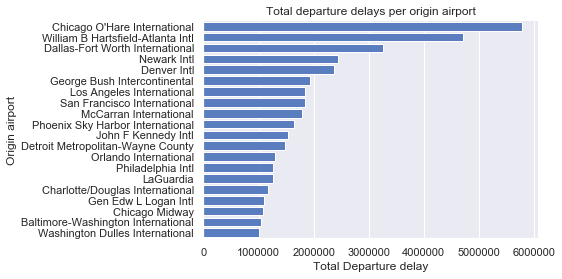

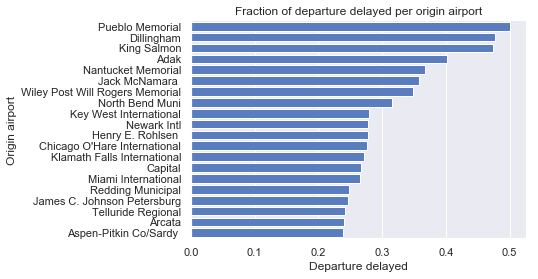

In [20]:
# 1. Plot delays per origin airports
most_delay_by_origin_20.rename(index=airport_dict, inplace=True)
plot_bar(most_delay_by_origin_20.values,most_delay_by_origin_20.index, 
         'Total Departure delay','Origin airport','Total departure delays per origin airport')

avg_delayed_by_origin_20 = avg_delayed_by_origin.nlargest(20)
avg_delayed_by_origin_20.rename(index=airport_dict, inplace=True)
plot_bar(avg_delayed_by_origin_20.values,avg_delayed_by_origin_20.index, 
         'Departure delayed','Origin airport','Fraction of departure delayed per origin airport')

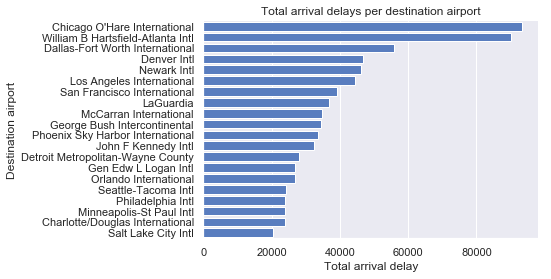

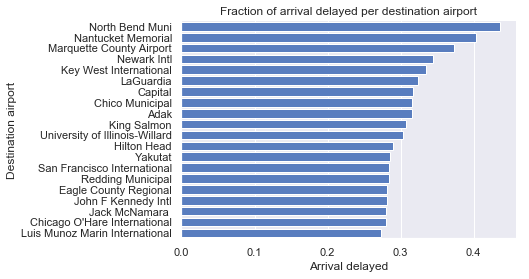

In [21]:
# 2. Plot delays per destination airport
most_delay_by_dest_20 = most_delay_by_dest.nlargest(20)
most_delay_by_dest_20.rename(index=airport_dict, inplace=True)
plot_bar(most_delay_by_dest_20.values,most_delay_by_dest_20.index, 
         'Total arrival delay','Destination airport','Total arrival delays per destination airport')

avg_delayed_by_dest_20 = avg_delayed_by_dest.nlargest(20)
avg_delayed_by_dest_20.rename(index=airport_dict, inplace=True)
plot_bar(avg_delayed_by_dest_20.values,avg_delayed_by_dest_20.index, 
         'Arrival delayed','Destination airport','Fraction of arrival delayed per destination airport')

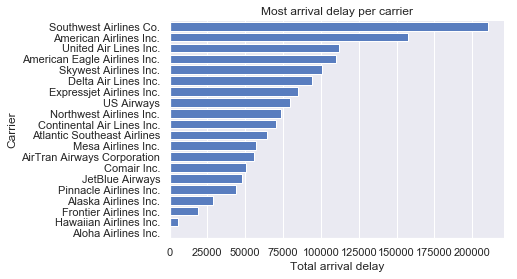

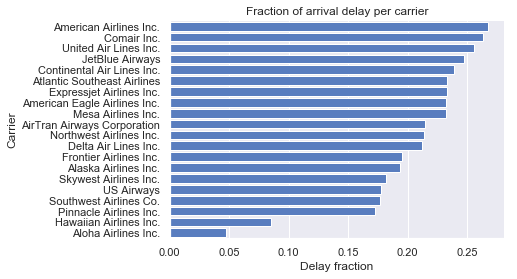

In [22]:
# 3. Plot delays per carrier
most_delayed_by_carrier_20.rename(index=carrier_dict, inplace=True)
plot_bar(most_delayed_by_carrier_20.values,most_delayed_by_carrier_20.index,
         'Total arrival delay','Carrier', 'Most arrival delay per carrier') 

avg_delayed_by_carrier = avg_delayed_by_carrier.nlargest(20)
avg_delayed_by_carrier.rename(index=carrier_dict, inplace=True)
plot_bar(avg_delayed_by_carrier.values,avg_delayed_by_carrier.index,
         'Delay fraction','Carrier', 'Fraction of arrival delay per carrier')  

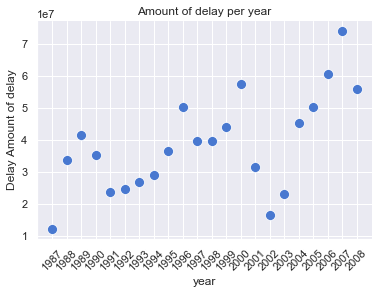

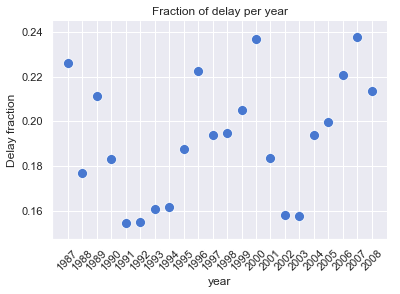

In [23]:
# 4. Plot delays per year
plot_scatter(most_delay_by_year.index, most_delay_by_year.values,
         'year','Delay Amount of delay', 'Amount of delay per year')

plot_scatter(avg_delayed_by_year.index, avg_delayed_by_year.values,
         'year','Delay fraction', 'Fraction of delay per year')


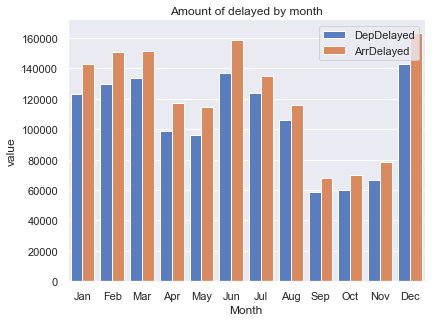

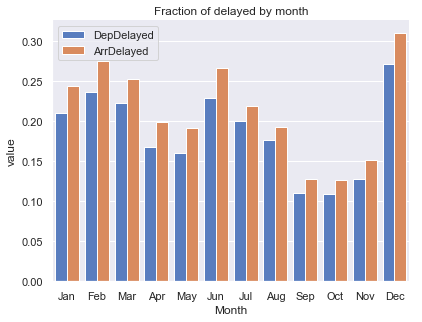

In [24]:
# 5. Plot delays per month
count_delayed_by_month.rename(index=month, inplace=True)
count_delayed_by_month = pd.melt(count_delayed_by_month.reset_index(), id_vars='Month')
plot_bar_melt(count_delayed_by_month ,'Month', 'value',"Month", "Amount of delayed by month")

# 6. Plot average amount of delays per month
avg_delayed_by_month.rename(index=month, inplace=True)
avg_delayed_by_month = pd.melt(avg_delayed_by_month.reset_index(), id_vars='Month')
plot_bar_melt(avg_delayed_by_month ,'Month', 'value',"Month", "Fraction of delayed by month")

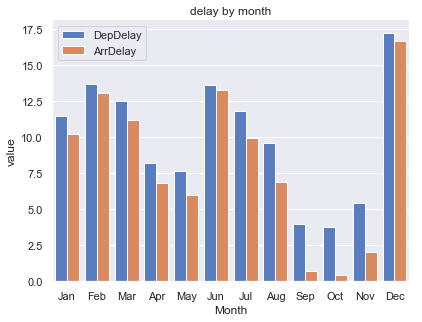

In [25]:
# 7. Plot average delay duration per month, this shows that on average the departure delay is heavier than the arrival delay.    
avg_delay_by_month.rename(index=month, inplace=True)
avg_delay_by_month = pd.melt(avg_delay_by_month.reset_index(), id_vars='Month')

plot_bar_melt(avg_delay_by_month ,'Month', 'value',"Month", "delay by month")

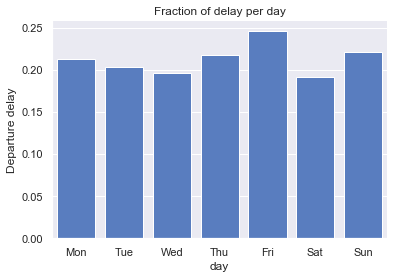

In [26]:
# 8. Plot average delays per day
avg_delayed_by_day.rename(index=day, inplace=True)
plot_bar(avg_delayed_by_day.index,avg_delayed_by_day.values ,
         'day','Departure delay', 'Fraction of delay per day')

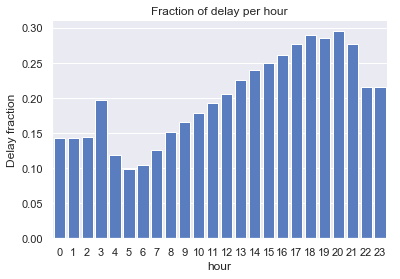

In [27]:
# 9. Plot average delays per hour
plot_bar(avg_delayed_by_hour.index.astype(int), avg_delayed_by_hour.values,
         'hour','Delay fraction', 'Fraction of delay per hour')    

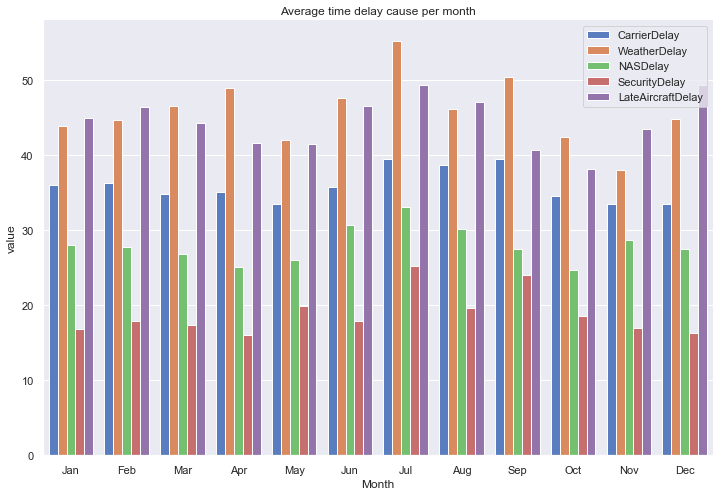

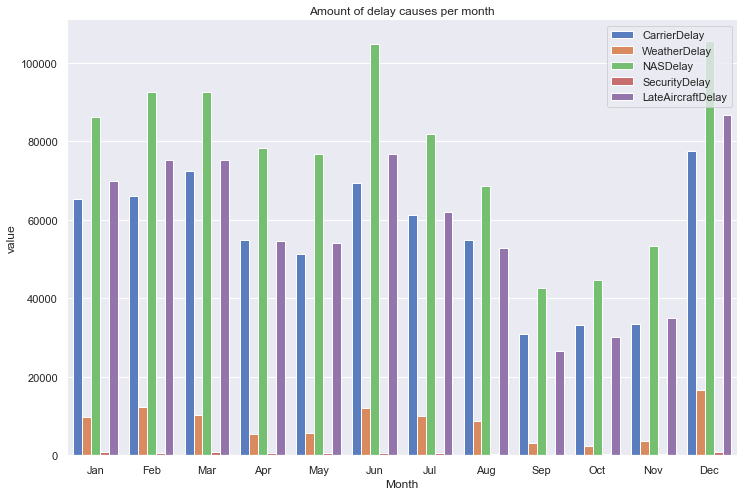

In [28]:
# 10. Plot delay causes --> This is usually registererd when the delay is > 15min at arrival.
avg_causes_by_month.rename(index=month, inplace=True)
avg_causes_by_month = pd.melt(avg_causes_by_month.reset_index(), id_vars='Month')    
plot_bar_melt(avg_causes_by_month ,'Month', 'value',"Month", "Average time delay cause per month",(12,8))

# 11. Plot delay causes
count_causes_by_month.rename(index=month, inplace=True)
count_causes_by_month = pd.melt(count_causes_by_month.reset_index(), id_vars='Month')
plot_bar_melt(count_causes_by_month ,'Month', 'value',"Month", "Amount of delay causes per month",(12,8))

## 1.3 Comparing the Airline carriers

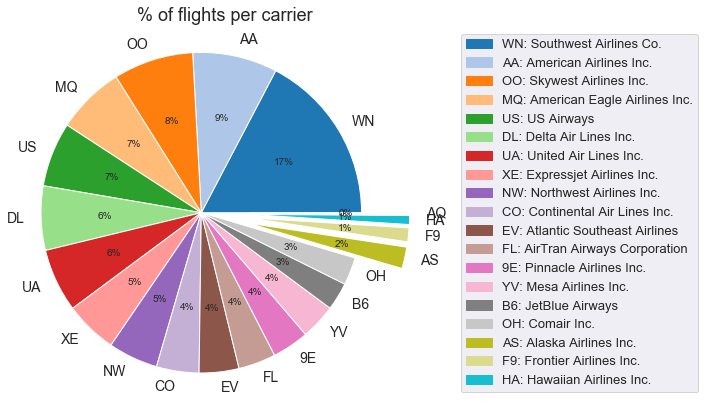

In [29]:
# 12. Let' s check the amount of flights per carrier in a pie chart
count_arrtime_by_carrier = count_arrtime_by_carrier.sort_values(ascending=False)
plot_piechart(count_arrtime_by_carrier, '% of flights per carrier',carrier_dict )

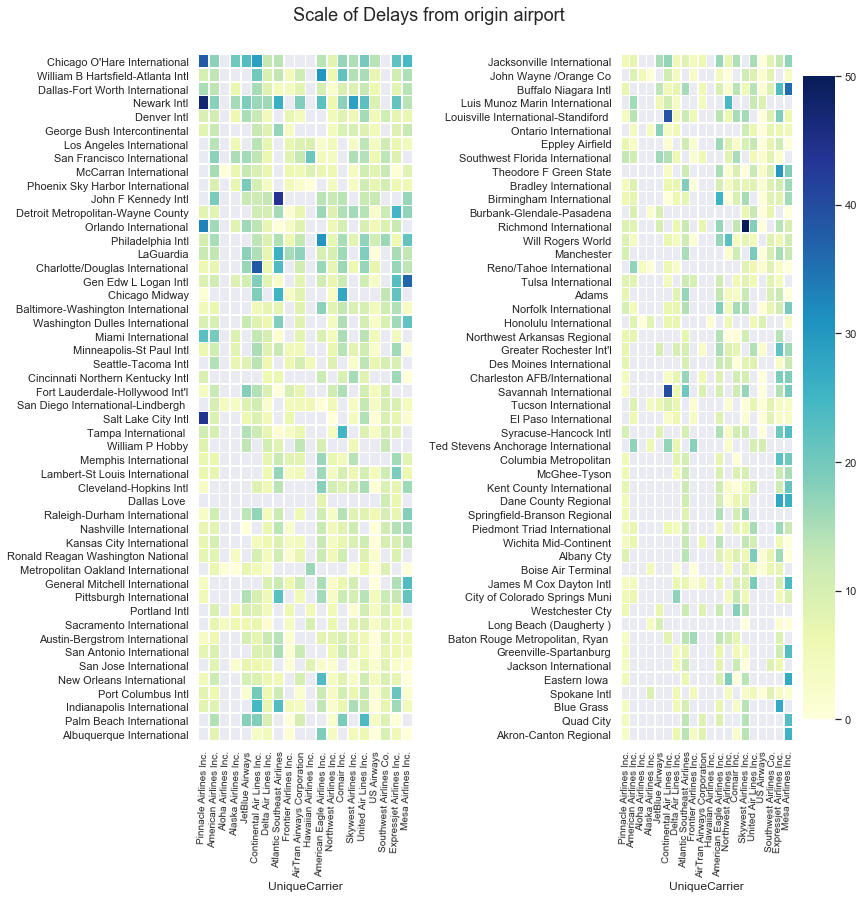

In [30]:
# 13. Plot delays from origin airport, we notice that most of the carriers don't exceed too much delay.However some airlines do have some bad delays.
# Most delays seem to come from outhwest airlines, however their delays never are very large. Pinacle and US airlines have much worse delays.
avg_delay_by_origin_and_carrier = avg_delay_by_origin_and_carrier.unstack()
avg_delay_by_origin_and_carrier = avg_delay_by_origin_and_carrier.loc[most_delay_by_origin_100.index, most_delayed_by_carrier.index].dropna(axis=1, thresh=1)

avg_delay_by_origin_and_carrier.rename(columns=carrier_dict, index=airport_dict, inplace=True)    
plot_heatmap(avg_delay_by_origin_and_carrier, "Scale of Delays from origin airport")

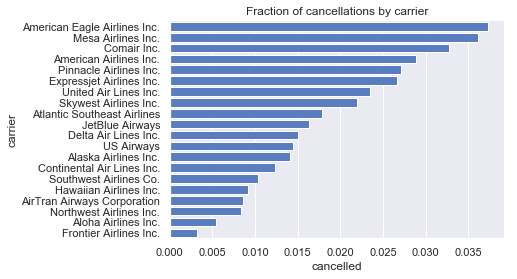

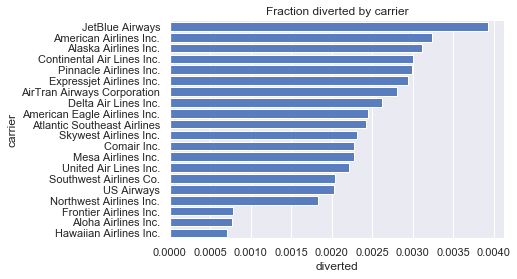

In [31]:
# 14. Let's check the % amount of cancellation and divertions
aggregations = (flight_delays.groupby('UniqueCarrier').Cancelled.mean().nlargest(20),
                flight_delays.groupby('UniqueCarrier').Diverted.mean().nlargest(20))
(most_cancelled_by_carrier,most_diverted_by_carrier) = dask.compute(*aggregations)

most_cancelled_by_carrier.rename(index=carrier_dict, inplace=True)
plot_bar(most_cancelled_by_carrier.values,most_cancelled_by_carrier.index, 
     'cancelled','carrier', 'Fraction of cancellations by carrier')

most_diverted_by_carrier.rename(index=carrier_dict, inplace=True)
plot_bar(most_diverted_by_carrier.values,most_diverted_by_carrier.index,
     'diverted','carrier', 'Fraction diverted by carrier')

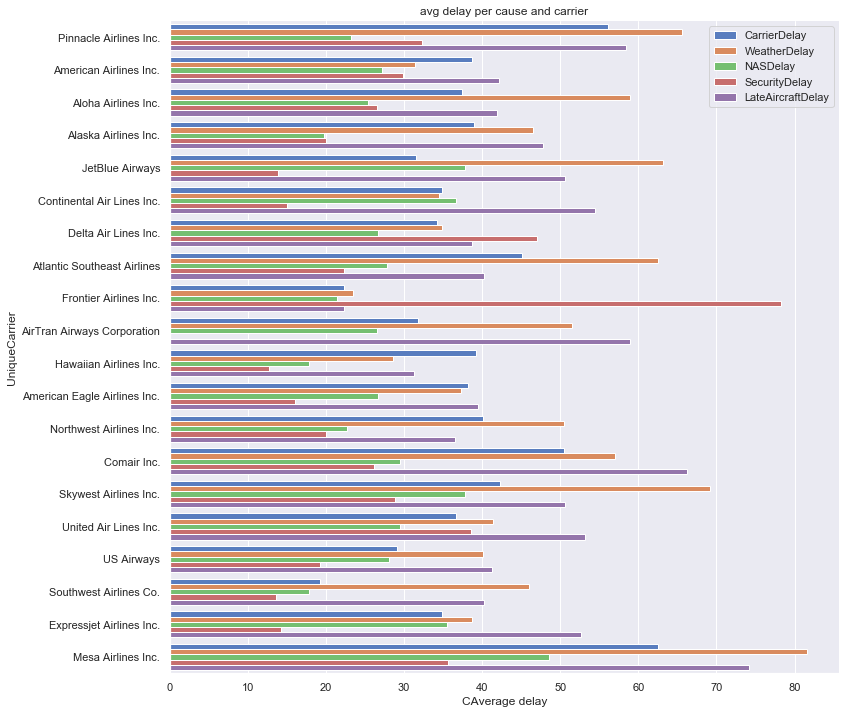

In [32]:
# 15. Now let's plot per carrier the cause of delays. This is only available for delayed flights (>15min) and not always recorded
avg_causes_by_carrier.rename(index=carrier_dict, inplace=True)
avg_causes_by_carrier = pd.melt(avg_causes_by_carrier.reset_index(), id_vars='UniqueCarrier')
plot_bar_melt(avg_causes_by_carrier ,'value', 'UniqueCarrier',"CAverage delay", "avg delay per cause and carrier",(12,12))

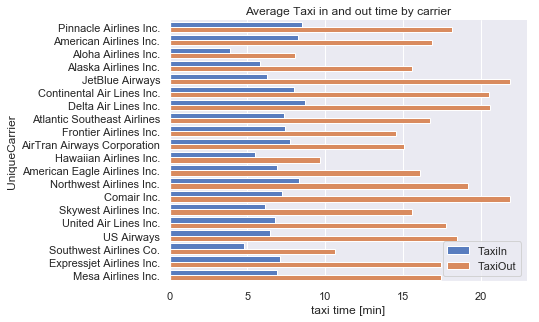

In [33]:
# 16. Let's take a look at the taxi in and taxi out time. It is clear that the outgoing taxi times are much higher as well as they differe heavily per carrier
avg_taxi_by_carrier.rename(index=carrier_dict, inplace=True)
avg_taxi_by_carrier = pd.melt(avg_taxi_by_carrier.reset_index(), id_vars='UniqueCarrier')
plot_bar_melt(avg_taxi_by_carrier ,'value', 'UniqueCarrier',"taxi time [min]", "Average Taxi in and out time by carrier")

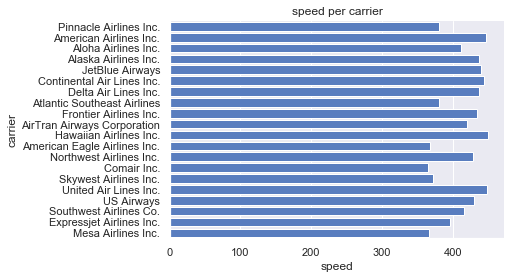

In [34]:
# 17. Airline speed is around 400mph, but far outliers are possible.
avg_speed_carrier = avg_speed_carrier[~avg_speed_carrier.isin([np.nan, np.inf, -np.inf]).any(1)]
avg_speed_carrier["Speed"] = (avg_speed_carrier["Distance"]/avg_speed_carrier["AirTime"]*60)
avg_speed_carrier = avg_speed_carrier.rename(index=carrier_dict).reset_index()
plot_bar(avg_speed_carrier['Speed'], avg_speed_carrier['UniqueCarrier'], 'speed', 'carrier','speed per carrier')

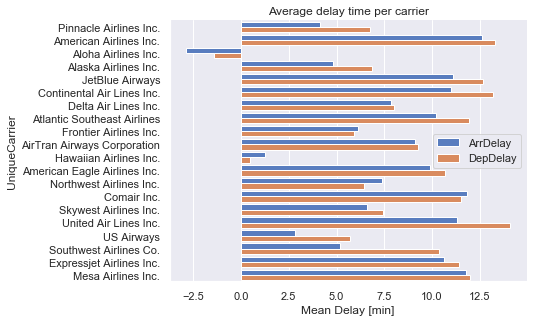

In [35]:
# 18. arrival and departure delays: Usually departure delays are longer than arrival delays, but this does not always seem to be the case.
avg_delay_by_carrier.rename(index=carrier_dict, inplace=True)
avg_delay_by_carrier = pd.melt(avg_delay_by_carrier.reset_index(), id_vars='UniqueCarrier')
plot_bar_melt(avg_delay_by_carrier ,'value', 'UniqueCarrier', "Mean Delay [min]", "Average delay time per carrier")

# 2. Predicting arrival delays

In the previous section we did some descriptive analysis of the data that has been recorded.
In this section we will focus on predicitve analysis; we will try to understand which features are important to predicting the departure delay. Our prediction model use case will be to given the flight data of a certain timeframe such as e.g the first 3 weeks of January 2008, predict the delays for the next week of January (23th till 31th). This can hence be useful for executives to improve flight service and delay time.

## 2.1 Correlation

In [36]:
# A heatmap helper function for the correlation matrix. This might take +- 5 min to calculate. Please have patience.
def plot_heatmap_corr(df, feature, name):
    fig = plt.figure(figsize=(25,15)) 
    corr = df[feature].corr()
    sns.heatmap(corr,cmap="RdBu_r", annot=True,center=0,xticklabels=corr.columns, yticklabels=corr.columns)
    plt.title(name)
    fig.savefig(join(read_path, "exports",  name + '.png'), bbox_inches='tight')

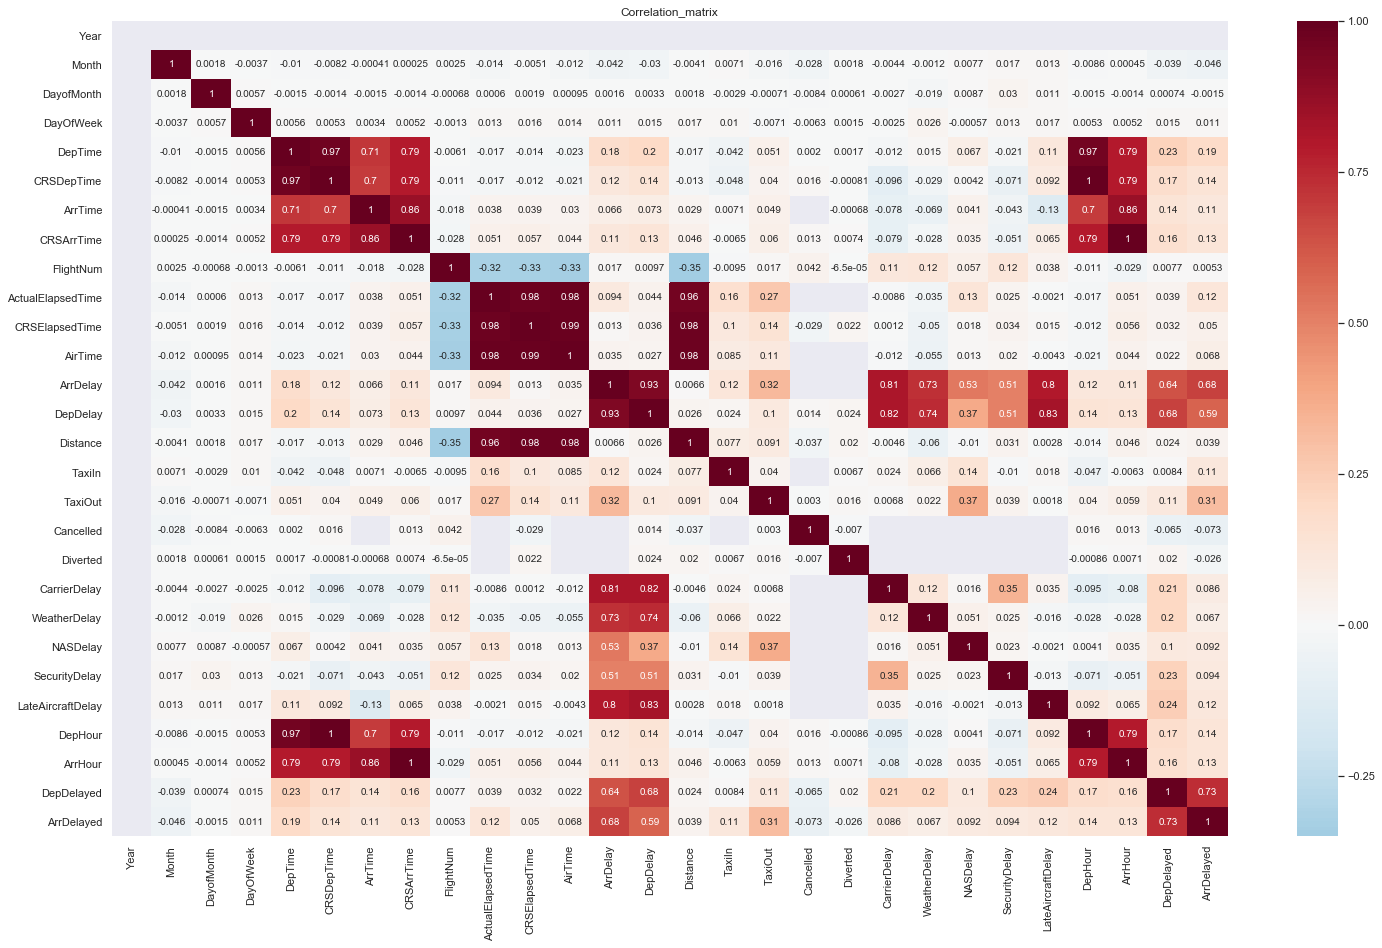

In [37]:
# Calculate the correlation and plot it
columns = list(persist_flight_delays.columns)
plot_heatmap_corr(persist_flight_delays, columns, 'Correlation_matrix')

There are some interesting insights to be gained from this correlation plot. 
* The arrival delay and departure delay are heavily correlated.
* Relative comapred to the other delay causes, it seems that LateAircraft delay seems most associated with the departure delay, but all delay causes are quite relevant to know if a departure/arrival will be delayed. 
* TaxiOut is quite associated for the departure delay but even more associated to arrival delays. TaxiIn is logically only related to the arrival delays, since it is only measurable at arrival.
* Further, the departure time and arrival time are heavily associated, which is why we will extract the hour.
* Finally the ActualElapsedTime is really relevant, which also makes sens

--> It is important to note that unfortunately most of these features will not be known at the time we will try to predict the departure delay. Since departure delay is less dependent on features only measured after the flight has taken place, but serves as a quite good proxy to (in case desired) to predict arrival delays, we will try to predict departure delays.

## 2.2 A simple classifier

We make our training data and our unseen test dataset on which we will be testing our model later on
* we will train our data on the first three weeks of january 2008 and carry out inference on the last week of january.
* We will use a stratified shuffle split to make sure there is balanced data ratio of 80/20 delay ratio in both train and test set.
* We will create a dummy simple classifier as baseline to compare against.
* We will then create a balanced logistic regression classifier to improve our model 
* We will do this in a sklearn pipeline, for reproducibility and executing same order of preprocesing on train and test set.
* We standardscale numerical columns, we one-hot encode low and high cardinal categorical columns 
* We plot ROC curve, Precision-Recall curve and learning curve, print the classsification report with F1, precision recall, 

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, StratifiedKFold, cross_val_predict, cross_validate

from sklearn.decomposition import PCA

from sklearn.base import BaseEstimator, TransformerMixin 
from pandas.api.types import CategoricalDtype

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, f1_score, auc, average_precision_score
from sklearn.metrics import make_scorer, precision_score, recall_score

In [39]:
# Let's define our columns and re-read our data from parquet if it isn't already loaded.
onehot_columns = ['Month','DayOfWeek', 'DepHour', 'UniqueCarrier', 'Origin', 'Dest']
numeric_columns = ['Distance']
target = 'DepDelayed'

columns = [target] + onehot_columns + numeric_columns

flight_delays = dd.read_parquet(os.path.join(read_path, "data", 'flight-delays-parquet'))

In [40]:
# Split the data in the training set and a test set.
df_train = flight_delays[(flight_delays['Month']==1) &(flight_delays['DayofMonth']<23)].reset_index()
df_test = flight_delays[(flight_delays['Month']==1) &(flight_delays['DayofMonth']>23)].reset_index()

In [41]:
# We define our X and y
df_train[onehot_columns] = df_train[onehot_columns].astype('object')
X = df_train[numeric_columns + onehot_columns].compute()

y = df_train[target].compute()

In [42]:
# Our target has an imbalanced class set: 80/20
y.value_counts()/len(y) 

False    0.794462
True     0.205538
Name: DepDelayed, dtype: float64

In [43]:
# Let's create a simple dummyclassifier as baseline model
# We will use DummyCLassifier as a baseline model which we will try to improve against.

from sklearn.dummy import DummyClassifier

Xdummy = X.copy()

X_training, X_val, y_training, y_val = train_test_split(Xdummy, y, 
                                                        train_size=0.75, 
                                                        random_state=42, 
                                                        stratify=y) 

classifier = DummyClassifier(strategy='stratified', random_state=42)
classifier.fit(X_training,y_training)
y_pred = classifier.predict(X_val)
y_pred_proba = classifier.predict_proba(X_val)[:,1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(classification_report(y_val,y_pred ))
print(roc_auc)

              precision    recall  f1-score   support

       False       0.79      0.79      0.79     85512
        True       0.20      0.20      0.20     22123

   micro avg       0.67      0.67      0.67    107635
   macro avg       0.50      0.50      0.50    107635
weighted avg       0.67      0.67      0.67    107635

0.4976243877164416


In [44]:
#Stratified sampling will be necessary to preserve class balances in our splits and to shuffle our data beforehand.
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in stratified.split(X, y):
    X_training, X_val = X.loc[train_index], X.loc[test_index]
    y_training, y_val= y.loc[train_index], y.loc[test_index]

In [45]:
class ColumnsSelector(BaseEstimator, TransformerMixin):
    '''Select columns based on a given type
    Args:
        type: (string) type such as e.g: int64, str, 
    '''        
    
    def __init__(self, type):
        self.type = type

    def fit(self, X, y=None):
        return self

    def transform(self,X):
        return X.select_dtypes(include=[self.type])

class CategoricalImputer(BaseEstimator, TransformerMixin):
    '''For categorical columns imputation will be done by chooosing a strategy,
    such as fill most frequent. Since sklearn imputer only works for
    numerical values. Fit will create a dictionary for a category and transform
    will impute.
  
    Args:
        strategy: (string) Default is imputation by most_frequent, 
                 if not then 0 is imputed
                 columns: (list) Provide the list of columns with missing values 
    '''

    def __init__(self, columns = None, strategy='most_frequent'):
        self.columns = columns
        self.strategy = strategy
    
    def fit(self,X, y=None):
        if self.columns is None:
            self.columns = X.columns
            
        if self.strategy is 'most_frequent':
            self.fill = {column: X[column].value_counts().index[0] for 
                         column in self.columns}
        else:
            self.fill = {column: '0' for column in self.columns}
            
        return self
    
    def transform(self,X):
        X_copy = X.copy()
        for column in self.columns:
            X_copy[column] = X_copy[column].fillna(self.fill[column])
        
        return X_copy


class CategoricalEncoder(BaseEstimator, TransformerMixin):
    
    ''' For categorical columns an encoding strategy is needed. Here we will
    choose pd.get_dummies, which is a one-hot encoding based strategy.
    Since we need to try to fit all possible categories, we will concatenate
    our feature data. This to prevent that we would encounter unseen categories.
    For each category will we transform to a corresponding column name with
    category type values.
    
    Args:
         dropfirst: (boolean) True drops the first column, this to prevent 
         multicollinearity. False keeps the first column.
    
    '''
    def __init__(self, dropFirst=True):
        self.categories=dict()
        self.dropFirst=dropFirst

    def fit(self, X, y=None):
        train = X.copy()
        train = train.select_dtypes(include=['object'])
        for column in train.columns:
            self.categories[column] = train[column].value_counts().index.tolist()
            
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.select_dtypes(include=['object'])
        for column in X_copy.columns:
            X_copy[column] = X_copy[column].astype({column:
                CategoricalDtype(self.categories[column])})
        
        return pd.get_dummies(X_copy, drop_first=self.dropFirst)


# Function to return the pipeline
# we need a pipeline for the numerical columns and the categorical columns, 
# combine them and return a preprocessed and full pipeline

def get_pipeline(model='logistic_regression'):

    pipeline_num = Pipeline([("num_selector", ColumnsSelector(type=np.number)),
                             #("num_imputer", NumericalImputer(columns=missing_cols, strategy=0)),
                             ("scaler", StandardScaler())])
    
    #missing_cols = ['']
    pipeline_cat = Pipeline([("cat_selector", ColumnsSelector(type='object')),
                             #("cat_imputer", CategoricalImputer(columns=missing_cols)),
                             ("encoder", CategoricalEncoder(dropFirst=True)),
                             ("PCA", PCA(n_components=100))])

    pipeline_processed = FeatureUnion([("pipeline_num", pipeline_num), 
                ("pipeline_cat", pipeline_cat)])
    
    pipeline_full = Pipeline([('pipeline_processed', pipeline_processed),
                              ('model',get_model_pipeline(model))])
    
    return pipeline_full, pipeline_processed

# Returns a model, if not specified, Logistic regression is returned as default:
def get_model_pipeline(model='logistic_regression'):
    
    if model == 'logistic_regression':
        pipeline_model=LogisticRegression(C=1,
                                          penalty='l2',
                                          random_state=42,
                                          class_weight='balanced') 
        
    elif model == 'random_forrest':
        pipeline_model=RandomForestClassifier(n_estimators = 128, 
                                              criterion = 'entropy', 
                                              max_depth=5, 
                                              random_state=42)
    
    
    elif model == 'xgboost':
        pipeline_model=XGBClassifier()
    
    elif model == 'neural_net':
        pipeline_model=keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model,
                                                              batch_size=10,
                                                              epochs=50,
                                                              shuffle=True,
                                                              input_dim=22)

    return pipeline_model

Now that all is in place, we can start our first model experiment. 

In [46]:
# Get our pipeline and fit the model on our training set
begin = time.time()
pipeline_full, pipeline_cat = get_pipeline('logistic_regression')
pipeline_full.fit(X_training, y_training)
end = time.time()
print(end-begin)


# For the evaluation set
y_val_pred = pipeline_full.predict(X_val)
y_val_probs = pipeline_full.predict_proba(X_val)
y_val_probs = y_val_probs[:,1] # predicting 0 or 1

33.10860586166382


In [47]:
# Plot Precision recall curve and export as png file
def plot_PR(y_test, y_probs, precision, recall, auc_val, filename):
  
    fig = plt.figure()
    plt.title('Precision recall curve')
    plt.plot(recall, precision, 'b', label = "{0:.2f} %".format(100*auc_val))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0.20, 0.20],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('precision')
    plt.xlabel('recall')
    fig.savefig(join(read_path, "exports",  filename + '.png'), bbox_inches='tight')

# Plot the confusion matrix and export as png file
def plot_CFM(y_test, y_pred, filename):
    fig = plt.figure()
    cfm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cfm, annot=True)
    plt.xlabel('Predicted classes')
    plt.ylabel('Actual classes')
    fig.savefig(join(read_path, "exports",  filename + '.png'), bbox_inches='tight')

# Plot the ROC curve and export as png file
def plot_ROC(y_test, y_pred, roc_auc, filename):
    fpr, tpr, threshold = roc_curve(y_test.values, y_pred)
    
    fig = plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = "{0:.2f} %".format(100*roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    fig.savefig(join(read_path, "exports",  filename + '.png'), bbox_inches='tight')

# Plot the learning curve and export as png file
def plot_curve(clf,X, y, title):
    sizes = np.linspace(0.01, 0.1, 3)
    train_sizes,train_scores,test_scores = learning_curve(clf,X,y,scoring='roc_auc',random_state = 42,cv = 5, train_sizes=sizes)

    fig = plt.figure()
    plt.title(title)
    
    ylim = (0.2, 1.01)
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.1,
                color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
        label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
        label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    fig.savefig(join(read_path, "exports",  filename + '.png'), bbox_inches='tight')

f1=0.40, auc=0.33,  ap=0.33
              precision    recall  f1-score   support

       False       0.86      0.59      0.70     68410
        True       0.29      0.64      0.40     17698

   micro avg       0.60      0.60      0.60     86108
   macro avg       0.57      0.61      0.55     86108
weighted avg       0.74      0.60      0.64     86108



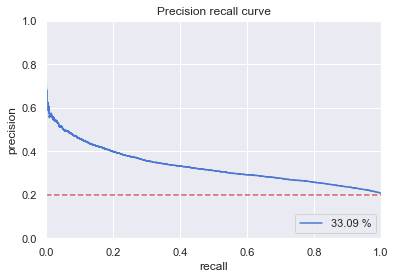

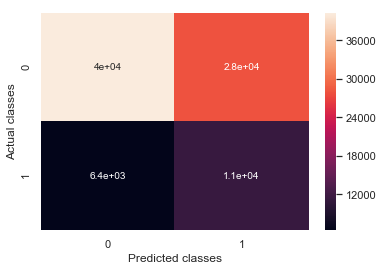

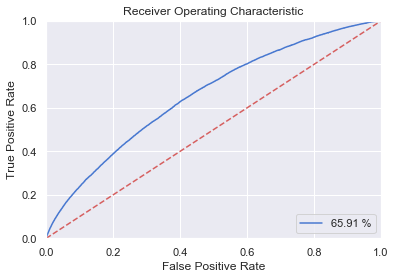

In [48]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val.values, y_val_probs)

# calculate precision-recall AUC
auc_val = auc(recall, precision)
ap = average_precision_score(y_val.values, y_val_probs)

# calculate F1 score
f1 = f1_score(y_val.values, y_val_pred)
print('f1=%.2f, auc=%.2f,  ap=%.2f' %(f1, auc_val, ap))

# Plot Precision-recall curve
plot_PR(y_val.values, y_val_probs, precision, recall, auc_val,'Precision_recall_curve')

# Plot the confusion matrix and the ROC curve
plot_CFM(y_val.values, y_val_pred, 'baseline_lr_confusion_matrix.png')
   
# Plot the ROC curve
roc_auc = roc_auc_score( y_val.values, y_val_probs) # Currently on a 0.68
plot_ROC(y_val, y_val_probs, roc_auc, 'baseline_lr_ROC.png')
#print("baseline AUC score: {0:.2f} %".format(100 * roc_auc))  

#Classification report including F1 score
print(classification_report(y_val.values,y_val_pred ))

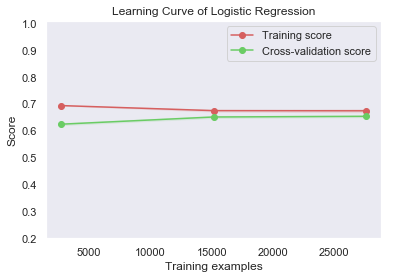

In [49]:
# plot learning curves. This shows us that there is actually not that much variance on our model, there could be many reasons either the model could 
# learn better if we do some more feature engineering either a different model could be fit. What we do learn from this
# Learning curve is that adding more examples will not necessarily improve the model.
X_processed =  pipeline_cat.fit_transform(X_training)
plot_curve(LogisticRegression(), X_processed, y_training,'Learning Curve of Logistic Regression')

In [50]:
# check the explained variance ratio of PCA
#pipeline_full.named_steps['pipeline_processed'].transformer_list[1][1].named_steps['PCA'].explained_variance_ratio_

In [51]:
# Finally we will do our inference 
df_test[onehot_columns] = df_test[onehot_columns].astype('object')
X_test = df_test[numeric_columns + onehot_columns].compute()
y_test = df_test[target].compute()

# For the evaluation set
y_test_pred = pipeline_full.predict(X_test)
y_test_probs = pipeline_full.predict_proba(X_test)
y_test_probs = y_test_probs[:,1] # predicting 1

f1=0.38, auc=0.29,  ap=0.29
              precision    recall  f1-score   support

       False       0.86      0.57      0.69    124412
        True       0.27      0.64      0.38     31044

   micro avg       0.58      0.58      0.58    155456
   macro avg       0.57      0.60      0.53    155456
weighted avg       0.74      0.58      0.63    155456



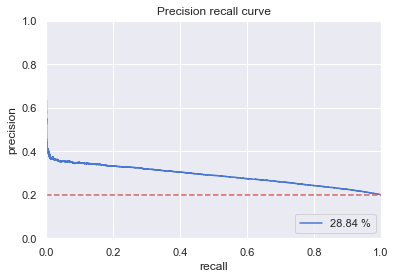

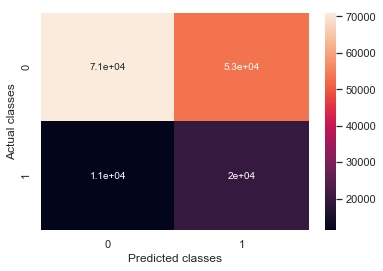

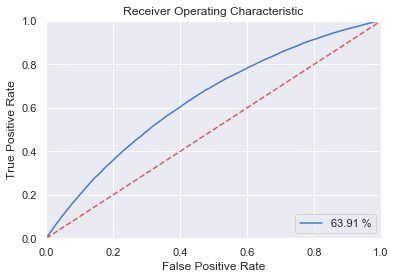

In [52]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test.values, y_test_probs)
# calculate precision-recall AUC
auc_val = auc(recall, precision)
ap = average_precision_score(y_test.values, y_test_probs)

# calculate F1 score
f1 = f1_score(y_test.values, y_test_pred)
print('f1=%.2f, auc=%.2f,  ap=%.2f' %(f1, auc_val, ap))

# predict probabilities
plot_PR(y_test.values, y_test_probs, precision, recall, auc_val,'Precision recall curve')

# Plot the confusion matrix and the ROC curve
plot_CFM(y_test.values, y_test_pred, 'baseline lr confusion_matrix.png')
   
# Plot the ROC curve
roc_auc = roc_auc_score( y_test.values, y_test_probs) # Currently on a 0.66
plot_ROC(y_test, y_test_probs, roc_auc, 'baseline lr ROC.png')
#print("baseline AUC score: {0:.2f} %".format(100 * roc_auc))  

#Classification report including F1 score
print(classification_report(y_test.values,y_test_pred ))

## 2.3 Model improvement (OPTIONAL)
!!! cross-validating against all models, takes a LOT of time, so beware!
We will now batch classify some other models cith cross validation in order to select a better model.


In [53]:
# Stratified shuffling will be necessary
# Standardscaling parameter boolean, True or False (Default)
# Returns a table with the 5 fold stratified cross validated metrics fot the given classifiers

def batch_classify(X, y, classifiers, standardscale=False):
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2,random_state=42)
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,1)), columns = ['clf'])

    count = 0
    for key,classifier in classifiers.items():
        for i, (train_index, test_index) in enumerate(cv.split(X,y)):
            X_training,X_test = X.iloc[train_index], X.iloc[test_index]
            y_training,y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Scaling of Features 
            if standardscale == True:
                sc_X = StandardScaler()
                X_training = sc_X.fit_transform(X_training)
                X_test = sc_X.transform(X_test)
            
            classifier.fit(X_training,y_training)
            y_val_pred = classifier.predict(X_test)
            y_probs = classifier.predict_proba(X_test)
            y_probs = y_probs[:,1]

            accuracy = accuracy_score(y_test,y_val_pred)
            precision = precision_score(y_test,y_val_pred)
            recall = recall_score(y_test,y_val_pred)
            roc_auc = roc_auc_score(y_test, y_probs)
            f1 = f1_score(y_test,y_val_pred)
            train_score = classifier.score(X_training, y_training)
            
            df_results.loc[count,'clf'] = key
            df_results.loc[count,'train_score'] = train_score
            df_results.loc[count, 'AUC'] = roc_auc
            df_results.loc[count, 'precision'] = precision
            df_results.loc[count, 'recall'] = recall
            df_results.loc[count, 'F1'] = f1
            count+=1
    
    df_results = df_results.groupby('clf', as_index=False).mean().round(3)
    return df_results

# plot the result
def plot_result(result):
    print(result_sorted)
    plt.xlabel('Accuracy')
    plt.title('Classifier F1 score')
    sns.set_color_codes("muted")
    sns.barplot(x='F1', y='clf', data=result, color="g")  
    plt.show()

In [54]:
# Define list of classifiers to run cv.

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


classifiers = {
                'Logistic Regression': LogisticRegression(C=1,
                                              penalty='l2',
                                              random_state=42,
                                              class_weight={1:5}),
                'Logistic Regression Balanced': LogisticRegression(C=1,
                                              penalty='l2',
                                              random_state=42,
                                              class_weight='balanced'),
                #'K Nearest Neighbour':KNeighborsClassifier(),
                'Decision Tree':DecisionTreeClassifier(class_weight='balanced',
                                                       random_state=42),
                #'Gaussian Naive Bayes':GaussianNB(),
                #'Support Vector':SVC(probability=True,
                #                     class_weight='balanced',
                #                     random_state=42),
                       }
no_classifiers = len(classifiers.keys())

                            clf  train_score    AUC  precision  recall     F1
2  Logistic Regression Balanced        0.625  0.672      0.300   0.629  0.406
1           Logistic Regression        0.532  0.671      0.272   0.767  0.401
0                 Decision Tree        0.836  0.562      0.272   0.385  0.319


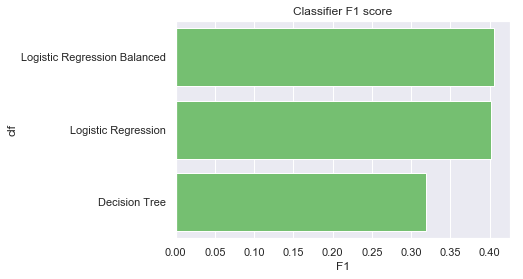

In [55]:
# Let's compare to other models using cross validation
X2_training = X_training.copy().fillna(0)
X2_training = pd.get_dummies(X2_training, drop_first=True)

result = batch_classify(X2_training,y_training, classifiers)
result_sorted = result.sort_values(by='F1', ascending=False)
plot_result(result_sorted)